# Importing libraries

In [16]:
!pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
!pip install pylatexenc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
from sklearn import model_selection, datasets, svm
from qiskit import QuantumCircuit, Aer, IBMQ, QuantumRegister, ClassicalRegister
import numpy as np
import qiskit
import copy
import matplotlib.pyplot as plt
np.random.seed(42)

# Importing the Iris Dataset


In [19]:
iris = datasets.load_iris()
X = iris.data[0:100]
Y = iris.target[0:100]
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.33, random_state=42)

# Hyperparameters

In [20]:
N = 4

# Designing the circuit

In [21]:
def feature_map(X, encoding_type):
    q = QuantumRegister(N)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q, c)
    if encoding_type == 'rx':
        for i, x in enumerate(X):
            qc.rx(x, i)
    elif encoding_type == 'ry':
        for i, x in enumerate(X):
            qc.ry(x, i)
    elif encoding_type == 'rz':
        for i, x in enumerate(X):
            qc.rz(x, i)    
    return qc, c

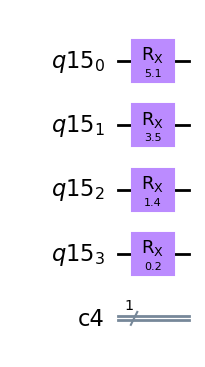

In [22]:
# feature map test
qc,c = feature_map(X[0], 'rx')
qc.draw('mpl')

# Using entanglment and parameteristaion

In [23]:
def variational_circuit(qc, theta, rotation_type):
    
    for i in range(N-1):
        qc.cnot(i, i+1)
    qc.cnot(N-1, 0)
    
    if rotation_type == 'rx':
        for i in range(N):
            qc.rx(theta[i], i)
    elif rotation_type == 'ry':
        for i in range(N):
            qc.ry(theta[i], i)
    elif rotation_type == 'rz':
        for i in range(N):
            qc.rz(theta[i], i)
            
    return qc

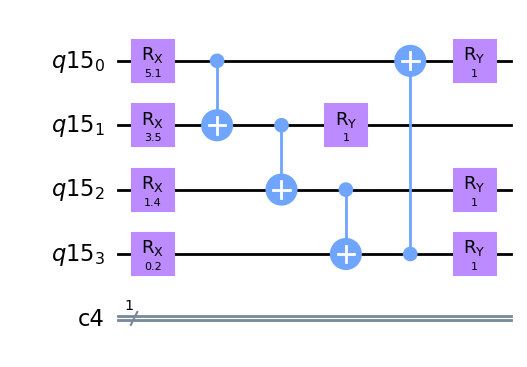

In [24]:
qc = variational_circuit(qc, np.ones(4), 'ry')
qc.draw('mpl')

# Defining the algorithm

In [25]:
def quantum_nn(X, theta, shots, encoding_type, rotation_type, simulator=True):
    
    qc, c = feature_map(X, encoding_type)
    qc = variational_circuit(qc, theta, rotation_type)
    qc.measure(0, c)

    backend = Aer.get_backend('qasm_simulator')
    
    if simulator == False:
        provider = IBMQ.load_account()
        backend = provider.get_backend('ibm_oslo')
        
    job = qiskit.execute(qc, backend, shots=shots)
    result = job.result()
    counts = result.get_counts(qc)
    
    return counts['1']/shots


In [26]:
qc, c = feature_map(X[0], 'rz')
qc = variational_circuit(qc, np.ones(4), 'rz')
qc.measure(0, c)
backend = Aer.get_backend('qasm_simulator')
    
job = qiskit.execute(qc, backend, shots=5000)
result = job.result()
counts = result.get_counts(qc)
print(counts)

{'0': 5000}


In [27]:
# quantum_nn test
quantum_nn(X[0], np.ones(4), 5000, 'rx', 'ry')

0.5462

# Defining the loss function

In [28]:
def loss(prediction, target):
    return(prediction-target)**2

In [29]:
# loss test
loss(quantum_nn(X[0], [0.9, 0.9, 0.9, 0.9], 5000, 'rx', 'ry'), Y[0])

0.29528356

# Defining the gradient function (gradient descent)

In [30]:
def gradient(X, Y, theta, delta, shots, encoding_type, rotation_type):

    grad = []
    for i in range(len(theta)):
        
        dtheta = copy.copy(theta)
        dtheta[i] += delta
        
        prediction_1 = quantum_nn(X, dtheta, shots, encoding_type, rotation_type)
        prediction_2 = quantum_nn(X, theta, shots, encoding_type, rotation_type)
        
        grad.append((loss(prediction_1, Y) - loss(prediction_2, Y)) / delta)
        
    return np.array(grad)

In [31]:
gradient(X[0], Y[0], np.ones(4), 0.01, 5000, 'rx', 'ry')

array([-0.31986 ,  0.402572, -0.173056, -0.129024])

# Defining Accuracy function

In [32]:
def accuracy(X, Y, theta, shots, encoding_type, rotation_type):
    
    counter = 0
    for X_i, Y_i, in zip(X, Y):
        prediction = quantum_nn(X_i, theta, shots, encoding_type, rotation_type)
        
        if prediction < 0.5 and Y_i == 0:
            counter += 1
        elif prediction >= 0.5 and Y_i == 1:
            counter += 1
            
    return counter/len(Y)

In [33]:
# Accuracy test
accuracy(X_test, Y_test, [-1.5, 1.2, 0.6, -0.2], 1000, 'rx', 'ry')

0.5151515151515151

In [34]:
def get_best_weight(accuracies, weights):
    return(weights[accuracies.index(max(accuracies))])

# Training

# Test 1

In [35]:

N = 4
def model(x_train, y_train, x_test, y_test, learning_rate, epochs, theta, shots, encoding_type, rotation_type, delta, optimizing_weights=False):
    loss_list = []
    acc_list = []
    weights_list = []

    print('Epoch \t Loss \t Training Accuracy \t theta')

    for i in range(epochs):
        loss_tmp = []


        for X_i, Y_i in zip(x_train, y_train):


            prediction = quantum_nn(X_i, theta, shots, encoding_type, rotation_type)
            loss_tmp.append(loss(prediction, Y_i))
            # update theta
            new_theta = theta - learning_rate * gradient(X_i, Y_i, theta, delta, shots, encoding_type, rotation_type)

            if loss(quantum_nn(X_i, new_theta, shots, encoding_type, rotation_type), Y_i) < loss(quantum_nn(X_i, theta, shots, encoding_type, rotation_type), Y_i):
                theta = new_theta

        loss_list.append(np.mean(loss_tmp))
        acc_list.append(accuracy(X_train, Y_train, theta, shots, encoding_type, rotation_type))
        weights_list.append(theta)
        
        print(f'{i} \t {round(loss_list[-1], 3)} \t {round(acc_list[-1], 3)} \t {theta} \t {len(weights_list)}')
    
    if optimizing_weights==True:
        acc = accuracy(x_test, y_test, get_best_weight(acc_list, weights_list), shots, encoding_type=encoding_gate, rotation_type=rotation_gate)
        return acc, get_best_weight(acc_list, weights_list), theta, loss_list, acc_list, weights_list
    else:
        acc = accuracy(x_test, y_test, theta, shots, encoding_type=encoding_gate, rotation_type=rotation_gate)
        return acc, theta, loss_list, acc_list, weights_list

In [36]:
gates = ['rx', 'ry', 'rz']
results = {}
for encoding_gate in gates:
    for rotation_gate in gates:
        circuit_type = encoding_gate + '-' + rotation_gate
        if circuit_type != 'rz-rz':
            print(f'Circuit type : {circuit_type} -> encoding : {encoding_gate} rotation : {rotation_gate}')
            acc, theta, loss_list, acc_list, weights_history = model(X_train, Y_train, X_test, Y_test, learning_rate=0.05, epochs=10, theta=np.ones(N), shots=5000, encoding_type=encoding_gate, rotation_type=rotation_gate, delta=0.01)
            results.update({circuit_type: {'accuracy': acc, 'theta': theta, 'loss_list':loss_list, 'acc_list':acc_list, 'weights_history_list':weights_history}})
            print(f" {circuit_type} accuracy : {results.get(circuit_type).get('accuracy')}")

Circuit type : rx-rx -> encoding : rx rotation : rx
Epoch 	 Loss 	 Training Accuracy 	 theta
0 	 0.278 	 0.224 	 [1.1611606 0.637697  0.9103454 0.5698176] 	 1
1 	 0.277 	 0.224 	 [1.2908502 0.6405474 1.6016342 0.7954962] 	 2
2 	 0.264 	 0.642 	 [1.6119706 0.6039682 1.3943492 0.9986764] 	 3
3 	 0.241 	 0.836 	 [1.763813  0.5865328 1.8412062 0.7499374] 	 4
4 	 0.23 	 0.746 	 [1.750824  0.473737  1.6550528 0.7471066] 	 5
5 	 0.237 	 0.791 	 [1.8876552 0.460843  1.403088  0.7696832] 	 6
6 	 0.226 	 0.806 	 [2.3255976 0.2261058 1.7683682 0.7805876] 	 7
7 	 0.211 	 0.851 	 [2.5847388 0.0192028 1.6225224 0.5454864] 	 8
8 	 0.207 	 0.821 	 [ 2.7880616 -0.1294344  0.970907   0.6896846] 	 9
9 	 0.203 	 0.836 	 [ 2.9061012 -0.3813442  0.4571252  0.4799312] 	 10
 rx-rx accuracy : 0.7272727272727273
Circuit type : rx-ry -> encoding : rx rotation : ry
Epoch 	 Loss 	 Training Accuracy 	 theta
0 	 0.255 	 0.776 	 [1.6681506 0.3042032 1.2635004 0.275239 ] 	 1
1 	 0.228 	 0.806 	 [ 2.1899916 -0.165095  

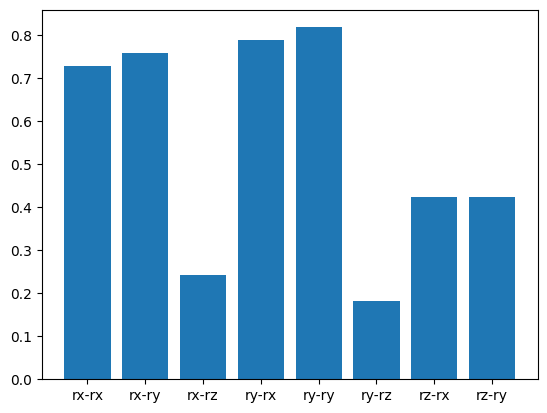

In [37]:
gates = ['rx', 'ry', 'rz']
labels = []
accuracies = []
for encoding_gate in gates:
    for rotation_gate in gates:
        circuit_type = encoding_gate + '-' + rotation_gate
        if circuit_type != 'rz-rz':
            labels.append(circuit_type)
            accuracies.append(results.get(circuit_type).get('accuracy'))
            
plt.bar(labels, accuracies)
plt.show()

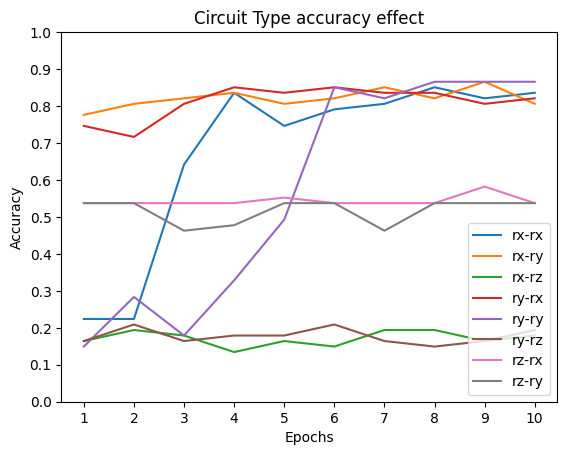

In [38]:
gates = ['rx', 'ry', 'rz']
labels = []
accuracies = []
for encoding_gate in gates:
    for rotation_gate in gates:
        circuit_type = encoding_gate + '-' + rotation_gate
        if circuit_type != 'rz-rz':
            plt.plot([x for x in range(1, 11)], results.get(circuit_type).get('acc_list'), label=circuit_type)
            
plt.xticks([x for x in range(1, 11)])
plt.yticks(np.arange (0, 1.1, 0.1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Circuit Type accuracy effect')
plt.legend()
plt.show()

In [39]:

N = 4
def model_1(x_train, y_train, x_test, y_test, learning_rate, epochs, theta, shots, encoding_type, rotation_type, delta, optimizing_weights=False):
    loss_list = []
    acc_list = []
    weights_list = []
    loss_val = 1
    i = 0
    print('Epoch \t Loss \t Training Accuracy \t theta')

    while loss_val > 0.17:
        
        loss_tmp = []


        for X_i, Y_i in zip(x_train, y_train):


            prediction = quantum_nn(X_i, theta, shots, encoding_type, rotation_type)
            loss_tmp.append(loss(prediction, Y_i))
            # update theta
            new_theta = theta - learning_rate * gradient(X_i, Y_i, theta, delta, shots, encoding_type, rotation_type)

            if loss(quantum_nn(X_i, new_theta, shots, encoding_type, rotation_type), Y_i) < loss(quantum_nn(X_i, theta, shots, encoding_type, rotation_type), Y_i):
                theta = new_theta
        loss_val = np.mean(loss_tmp)
        loss_list.append(np.mean(loss_tmp))
        acc_list.append(accuracy(X_train, Y_train, theta, shots, encoding_type, rotation_type))
        weights_list.append(theta)
        
        print(f'{i} \t {round(loss_list[-1], 3)} \t {round(acc_list[-1], 3)} \t {theta} \t {len(weights_list)}')
        i = i + 1
    
    return theta, loss_list, acc_list, weights_list

In [40]:
theta_b, loss_list_b, acc_list_b, weights_history_b = model_1(X_train, Y_train, X_test, Y_test, learning_rate=0.05, epochs=20, theta=np.ones(N), shots=5000, encoding_type='ry', rotation_type='ry', delta=0.01)

Epoch 	 Loss 	 Training Accuracy 	 theta
0 	 0.378 	 0.119 	 [0.4962932 0.8204036 1.2096664 0.569984 ] 	 1
1 	 0.329 	 0.448 	 [-0.555775   0.5676758  1.3213806  0.4783724] 	 2
2 	 0.225 	 0.716 	 [-1.3530012  0.7102732  1.0794848 -0.253714 ] 	 3
3 	 0.193 	 0.761 	 [-1.4322514  0.9120676  0.7627396 -0.3017956] 	 4
4 	 0.187 	 0.776 	 [-1.7334962  0.744185   0.6772558 -0.510979 ] 	 5
5 	 0.177 	 0.761 	 [-1.8340976  0.8914732  0.7058126 -0.7744442] 	 6
6 	 0.177 	 0.776 	 [-1.7267406  0.9221532  0.5461468 -0.5049894] 	 7
7 	 0.181 	 0.791 	 [-1.897247   0.8833272  0.6152216 -0.8331612] 	 8
8 	 0.175 	 0.806 	 [-1.963138   0.1482062  0.6003142 -0.6461248] 	 9
9 	 0.173 	 0.866 	 [-2.2229824  0.093485   0.6959152 -0.568226 ] 	 10
10 	 0.17 	 0.836 	 [-2.1483116  0.0072874  0.834897  -0.6320296] 	 11


In [41]:

N = 4
def model_2(x_train, y_train, x_test, y_test, learning_rate, epochs, theta, shots, encoding_type, rotation_type, delta, optimizing_weights=False):
    loss_list = []
    acc_list = []
    weights_list = []

    print('Epoch \t Loss \t Training Accuracy \t theta')

    for i in range(epochs):
        loss_tmp = []


        for X_i, Y_i in zip(x_train, y_train):


            prediction = quantum_nn(X_i, theta, shots, encoding_type, rotation_type)
            loss_tmp.append(loss(prediction, Y_i))
            # update theta
            new_theta = theta - learning_rate * gradient(X_i, Y_i, theta, delta, shots, encoding_type, rotation_type)

            if loss(quantum_nn(X_i, new_theta, shots, encoding_type, rotation_type), Y_i) < loss(quantum_nn(X_i, theta, shots, encoding_type, rotation_type), Y_i):
                theta = new_theta

        loss_list.append(np.mean(loss_tmp))
        acc_list.append(accuracy(X_train, Y_train, theta, shots, encoding_type, rotation_type))
        weights_list.append(theta)
        
        print(f'{i} \t {round(loss_list[-1], 3)} \t {round(acc_list[-1], 3)} \t {theta} \t {len(weights_list)}')
    
    return theta, loss_list, acc_list, weights_list

In [42]:
for learning_rate in [0.001, 0.01, 0.05, 0.1]:
    theta, loss_list, acc_list, weights_history = model_2(X_train, Y_train, X_test, Y_test, learning_rate=learning_rate, epochs=20, theta=np.ones(N), shots=5000, encoding_type='ry', rotation_type='ry', delta=0.01)
    acc = accuracy(X_test, Y_test, theta, 5000, encoding_type='ry', rotation_type='ry')
    results.update({learning_rate: {'accuracy': acc, 'theta': theta, 'loss_list':loss_list, 'acc_list':acc_list, 'weights_history_list':weights_history}})
    print(f" Learning rate : {learning_rate} accuracy : {results.get(learning_rate).get('accuracy')}")

Epoch 	 Loss 	 Training Accuracy 	 theta
0 	 0.384 	 0.179 	 [1.00533292 1.00030587 0.99242362 0.99019551] 	 1
1 	 0.385 	 0.164 	 [1.00355648 0.99464015 1.00103171 0.99170026] 	 2
2 	 0.383 	 0.149 	 [1.00156402 0.99067922 1.00581594 1.00465334] 	 3
3 	 0.384 	 0.149 	 [1.00417068 0.98711594 1.00074713 1.00498292] 	 4
4 	 0.384 	 0.179 	 [1.00371302 0.99198766 0.99988372 1.00648168] 	 5
5 	 0.384 	 0.164 	 [1.00891732 0.99056664 1.00460663 1.01051219] 	 6
6 	 0.382 	 0.149 	 [1.0059737  1.01108548 1.006621   1.01126466] 	 7
7 	 0.382 	 0.164 	 [1.00321818 1.00855152 1.01075488 1.00539663] 	 8
8 	 0.383 	 0.164 	 [1.00826096 1.0197829  1.0181852  1.01154133] 	 9
9 	 0.384 	 0.149 	 [1.01223995 1.01079966 1.02236096 1.01008345] 	 10
10 	 0.385 	 0.134 	 [1.02322845 1.01685316 1.02206931 1.004707  ] 	 11
11 	 0.382 	 0.209 	 [1.01822422 1.02103994 1.03009507 0.99954849] 	 12
12 	 0.384 	 0.179 	 [1.02697778 1.01454847 1.0354368  0.99113451] 	 13
13 	 0.386 	 0.149 	 [1.02703662 1.0176005

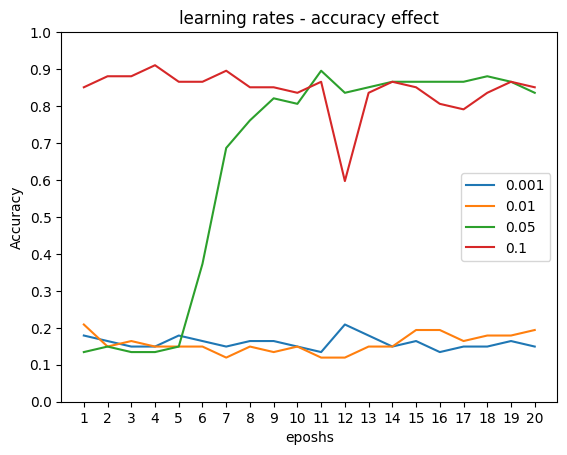

In [43]:
for learning_rate in [0.001, 0.01, 0.05, 0.1]:
    plt.plot([x for x in range(1, 21)], results.get(learning_rate).get('acc_list'), label=learning_rate)
            
plt.xticks([x for x in range(1, 21)])
plt.yticks(np.arange (0, 1.1, 0.1))
plt.xlabel('eposhs')
plt.ylabel('Accuracy')
plt.title('learning rates - accuracy effect')
plt.legend()
plt.show()

In [44]:
n_shots_results = {}
for n_shots in [1000, 5000, 10000, 50000]:
    theta, loss_list, acc_list, weights_history = model_2(X_train, Y_train, X_test, Y_test, learning_rate=0.05, epochs=20, theta=np.ones(N), shots=n_shots, encoding_type='ry', rotation_type='ry', delta=0.01)
    acc = accuracy(X_test, Y_test, theta, n_shots, encoding_type='ry', rotation_type='ry')
    n_shots_results.update({n_shots: {'accuracy': acc, 'theta': theta, 'loss_list':loss_list, 'acc_list':acc_list, 'weights_history_list':weights_history}})
    print(f" Number of Shots : {n_shots} accuracy : {n_shots_results.get(n_shots).get('accuracy')}")

Epoch 	 Loss 	 Training Accuracy 	 theta
0 	 0.312 	 0.716 	 [-1.214965  1.34608   1.37028   1.35779 ] 	 1
1 	 0.18 	 0.821 	 [-2.44062   1.369175  1.654335  0.590825] 	 2
2 	 0.172 	 0.836 	 [-2.4956    2.011235  2.284085 -0.751485] 	 3
3 	 0.171 	 0.836 	 [-2.183995  2.29825   2.49396  -1.08293 ] 	 4
4 	 0.17 	 0.836 	 [-2.31063   1.7787    1.999295 -0.579145] 	 5
5 	 0.173 	 0.776 	 [-2.411345  1.82391   1.24462  -1.250445] 	 6
6 	 0.17 	 0.791 	 [-1.864965  1.525745  1.3986   -0.49936 ] 	 7
7 	 0.169 	 0.836 	 [-2.50852   1.340525  1.562385 -0.900915] 	 8
8 	 0.173 	 0.866 	 [-2.17271   1.723285  1.70652  -1.64919 ] 	 9
9 	 0.169 	 0.851 	 [-2.18327   2.20718   1.22044  -1.212765] 	 10
10 	 0.173 	 0.791 	 [-1.7026    1.98025   0.892675 -2.26546 ] 	 11
11 	 0.176 	 0.806 	 [-2.00569   2.51313  -0.02521  -2.295815] 	 12
12 	 0.176 	 0.806 	 [-2.17152   2.491325 -0.729865 -2.19875 ] 	 13
13 	 0.167 	 0.761 	 [-1.99919   2.08649  -1.044155 -2.14675 ] 	 14
14 	 0.168 	 0.821 	 [-1.9689

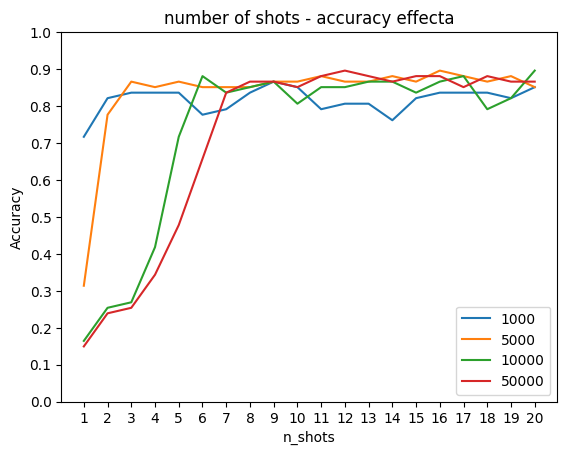

In [45]:
shots_list = [1000, 5000, 10000, 50000]
for n_shots in shots_list:
    plt.plot([x for x in range(1, 21)], n_shots_results.get(n_shots).get('acc_list'), label=n_shots)
            
plt.xticks([x for x in range(1, 21)])
plt.yticks(np.arange (0, 1.1, 0.1))
plt.xlabel('n_shots')
plt.ylabel('Accuracy')
plt.title('number of shots - accuracy effecta')
plt.legend()
plt.show()

In [46]:
delta_results = {}
for delta in [0.01, 0.05, 0.1, 1]:
    theta, loss_list, acc_list, weights_history = model_2(X_train, Y_train, X_test, Y_test, learning_rate=0.1, epochs=20, theta=np.ones(N), shots=1000, encoding_type='ry', rotation_type='ry', delta=delta)
    acc = accuracy(X_test, Y_test, theta, 1000, encoding_type='ry', rotation_type='ry')
    delta_results.update({delta: {'accuracy': acc, 'theta': theta, 'loss_list':loss_list, 'acc_list':acc_list, 'weights_history_list':weights_history}})
    print(f" Delta : {delta} accuracy : {delta_results.get(delta).get('accuracy')}")

Epoch 	 Loss 	 Training Accuracy 	 theta
0 	 0.235 	 0.612 	 [-3.43154  0.80122 -0.02368  2.35058] 	 1
1 	 0.213 	 0.448 	 [-3.90186 -0.25379  0.99392 -0.15892] 	 2
2 	 0.194 	 0.851 	 [-2.42687 -1.16164 -1.24525  1.34252] 	 3
3 	 0.177 	 0.866 	 [-2.68679 -0.25086 -0.90632  1.55574] 	 4
4 	 0.172 	 0.866 	 [-2.29055 -0.41945 -0.16254  1.59756] 	 5
5 	 0.176 	 0.806 	 [-1.95205 -0.71111 -1.43798  3.31671] 	 6
6 	 0.174 	 0.896 	 [-2.8683  -0.82863 -1.00414  3.17036] 	 7
7 	 0.177 	 0.836 	 [-2.03915 -0.81796 -0.91176  3.23623] 	 8
8 	 0.182 	 0.836 	 [-2.43111  0.31075 -0.63195  1.94833] 	 9
9 	 0.173 	 0.866 	 [-2.59156 -0.55974  1.02742  3.36128] 	 10
10 	 0.177 	 0.791 	 [-2.1059  -0.84138  1.66388  2.27543] 	 11
11 	 0.17 	 0.866 	 [-2.53106 -0.31863  0.46373  1.7055 ] 	 12
12 	 0.194 	 0.821 	 [-3.04661 -1.31924  0.42812  0.84145] 	 13
13 	 0.171 	 0.836 	 [-2.15277 -0.78041  0.11884  0.34368] 	 14
14 	 0.171 	 0.776 	 [-1.63273 -1.23997 -0.64036 -0.0511 ] 	 15
15 	 0.177 	 0.821 

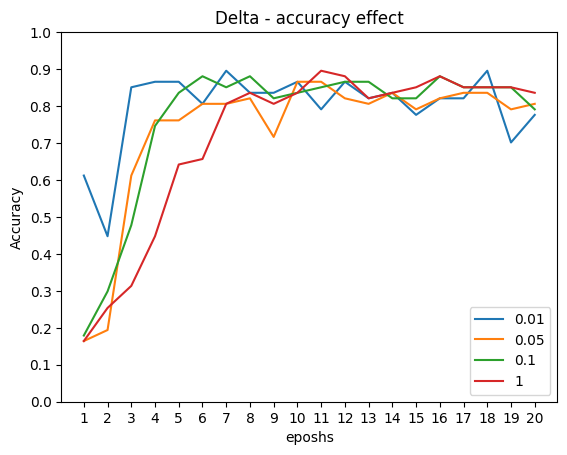

In [47]:
for delta in [0.01, 0.05, 0.1, 1]:
    plt.plot([x for x in range(1, 21)], delta_results.get(delta).get('acc_list'), label=delta)
            
plt.xticks([x for x in range(1, 21)])
plt.yticks(np.arange (0, 1.1, 0.1))
plt.xlabel('eposhs')
plt.ylabel('Accuracy')
plt.title('Delta - accuracy effect')
plt.legend()
plt.show()

In [48]:
def feature_map_2(X, theta):
    n = 4

    qr = QuantumRegister(4)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(qr,c )
    for i, x in enumerate(X):
        qc.ry(x, i)
    for i in range(n-1):
        qc.cx(i, i+1)

    qc.barrier()
    for i in range(4):
        qc.rz(theta[i], i)
    qc.barrier()

    for i in reversed(range(n-1)):
        qc.cx(i, i+1)
    qc.h(0)

    return qc, c

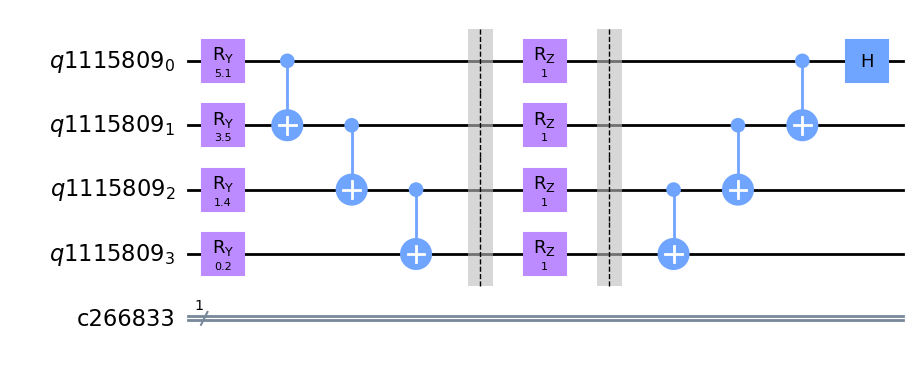

In [49]:
qc, c = feature_map_2(X[0], np.ones(4))
qc.draw('mpl')

In [50]:
def quantum_nn(X, theta, shots, encoding_type=None, rotation_type=None, simulator=True):
    
    qc, c = feature_map_2(X, theta)
    qc.measure(0, c)

    backend = Aer.get_backend('qasm_simulator')
    
    if simulator == False:
        provider = IBMQ.load_account()
        backend = provider.get_backend('ibm_oslo')
        
    job = qiskit.execute(qc, backend, shots=shots)
    result = job.result()
    counts = result.get_counts(qc)
    
    return counts['1']/shots

In [51]:
def accuracy(X, Y, theta, shots):
    
    counter = 0
    for X_i, Y_i, in zip(X, Y):
        prediction = quantum_nn(X_i, theta, shots)
        
        if prediction < 0.5 and Y_i == 0:
            counter += 1
        elif prediction >= 0.5 and Y_i == 1:
            counter += 1
            
    return counter/len(Y)

In [52]:
def gradient(X, Y, theta, delta, shots):

    grad = []
    for i in range(len(theta)):
        
        dtheta = copy.copy(theta)
        dtheta[i] += delta
        
        prediction_1 = quantum_nn(X, dtheta, shots)
        prediction_2 = quantum_nn(X, theta, shots)
        
        grad.append((loss(prediction_1, Y) - loss(prediction_2, Y)) / delta)
        
    return np.array(grad)

In [53]:
N = 4
def model_5(x_train, y_train, x_test, y_test, learning_rate, epochs, theta, shots, delta, optimizing_weights=False):
    loss_list = []
    acc_list = []
    weights_list = []

    print('Epoch \t Loss \t Training Accuracy \t theta')

    for i in range(epochs):
        loss_tmp = []


        for X_i, Y_i in zip(x_train, y_train):


            prediction = quantum_nn(X_i, theta, shots)
            loss_tmp.append(loss(prediction, Y_i))
            # update theta
            new_theta = theta - learning_rate * gradient(X_i, Y_i, theta, delta, shots)

            if loss(quantum_nn(X_i, new_theta, shots), Y_i) < loss(quantum_nn(X_i, theta, shots), Y_i):
                theta = new_theta

        loss_list.append(np.mean(loss_tmp))
        acc_list.append(accuracy(X_train, Y_train, theta, shots))
        weights_list.append(theta)
        
        print(f'{i} \t {round(loss_list[-1], 3)} \t {round(acc_list[-1], 3)} \t {theta} \t {len(weights_list)}')
    
    return theta, loss_list, acc_list, weights_list

In [54]:
theta, loss_list, acc_list, weights_list = model_5(X_train, Y_train, X_test, Y_test, 0.01, 100, [1, 1, 1, 1], 5000, 0.01)

Epoch 	 Loss 	 Training Accuracy 	 theta
0 	 0.178 	 0.806 	 [0.97187548 1.02188308 0.97758392 1.06533124] 	 1
1 	 0.172 	 0.821 	 [0.96075992 1.08043176 1.02499596 1.03691504] 	 2
2 	 0.169 	 0.866 	 [0.89186696 1.10047468 0.99437256 1.05030604] 	 3
3 	 0.172 	 0.806 	 [0.9055198  1.09012556 1.0377654  1.10058952] 	 4
4 	 0.162 	 0.851 	 [0.82689572 1.13592732 1.014774   1.13242788] 	 5
5 	 0.163 	 0.851 	 [0.81232644 1.19680432 1.00660528 1.10063112] 	 6
6 	 0.159 	 0.821 	 [0.75116584 1.13341692 1.09183848 1.12971028] 	 7
7 	 0.158 	 0.701 	 [0.74076068 1.10780864 1.11331012 1.20916336] 	 8
8 	 0.157 	 0.851 	 [0.6914574  1.06093684 1.00144732 1.1787118 ] 	 9
9 	 0.159 	 0.806 	 [0.65654904 1.09398852 1.03322464 1.16348772] 	 10
10 	 0.155 	 0.791 	 [0.67163496 1.120801   1.10699572 1.11163796] 	 11
11 	 0.158 	 0.791 	 [0.70770632 1.03311192 1.12394788 1.09391996] 	 12
12 	 0.158 	 0.836 	 [0.68658872 1.04582552 1.1715148  1.06216088] 	 13
13 	 0.158 	 0.761 	 [0.7163874  1.0138816

In [55]:
accuracy(X_test, Y_test, theta, 5000)

0.9090909090909091

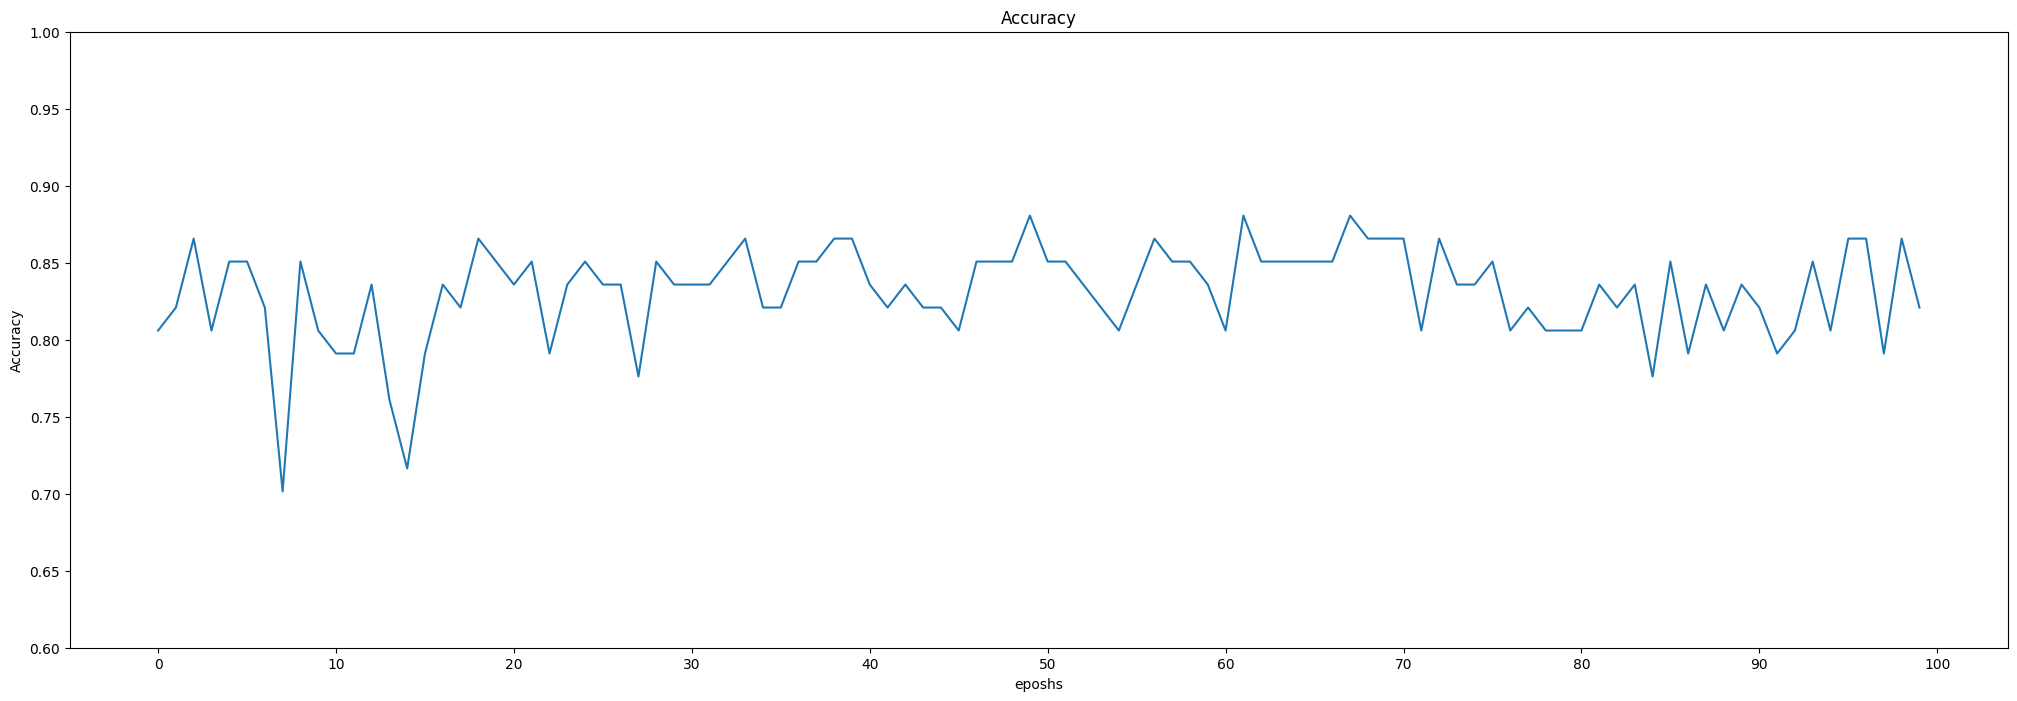

In [56]:
plt.figure(figsize=(25, 8))
plt.plot([x for x in range(0, 100)], acc_list)
plt.xticks([x for x in range(0, 101, 10)])
plt.ylim([0.6, 1])
plt.xlabel('eposhs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.show()

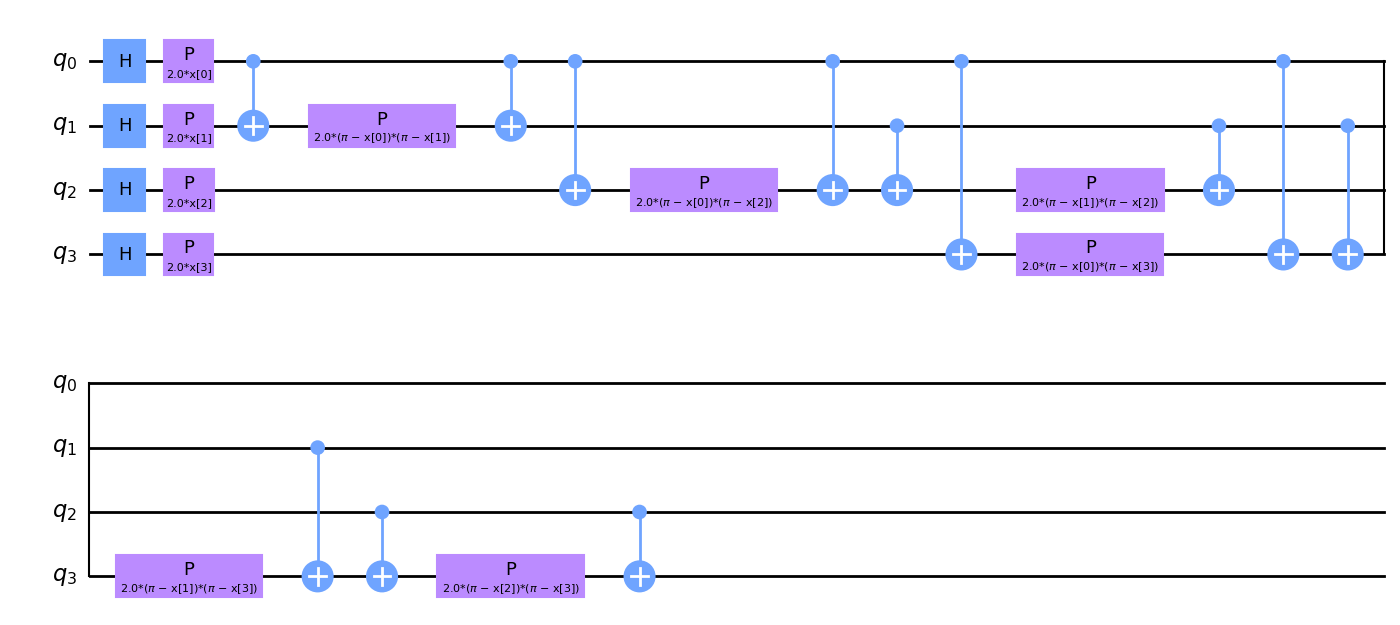

In [57]:
from qiskit.circuit.library import ZZFeatureMap

num_features = X_train.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", fold=20)

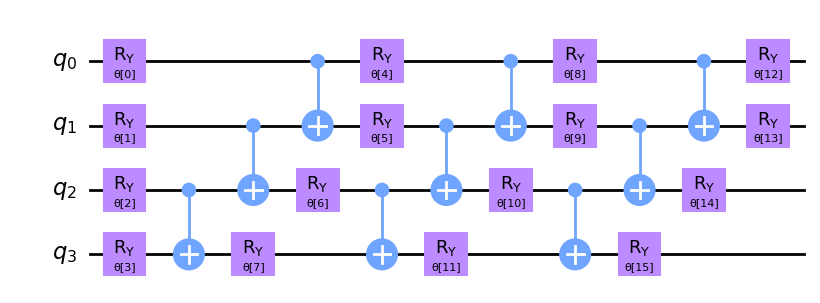

In [58]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", fold=20)

In [59]:
from qiskit.algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=100)

In [60]:
from qiskit.primitives import Sampler

sampler = Sampler()

In [61]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [62]:
!pip install qiskit[machine-learning]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 15.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 12.9 MB/s eta 0:00:00
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=517919 sha256=1e7e5f3f08286f96dc8072121c798cca297b7d15e28f75fa43dd40582567defc
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw
  Attempting uninstall: dill
    Found existing installation: dill 0.3.6
    Uninstalling dill-0.3.6:
      Successfully uninstalled dill-0.3.6


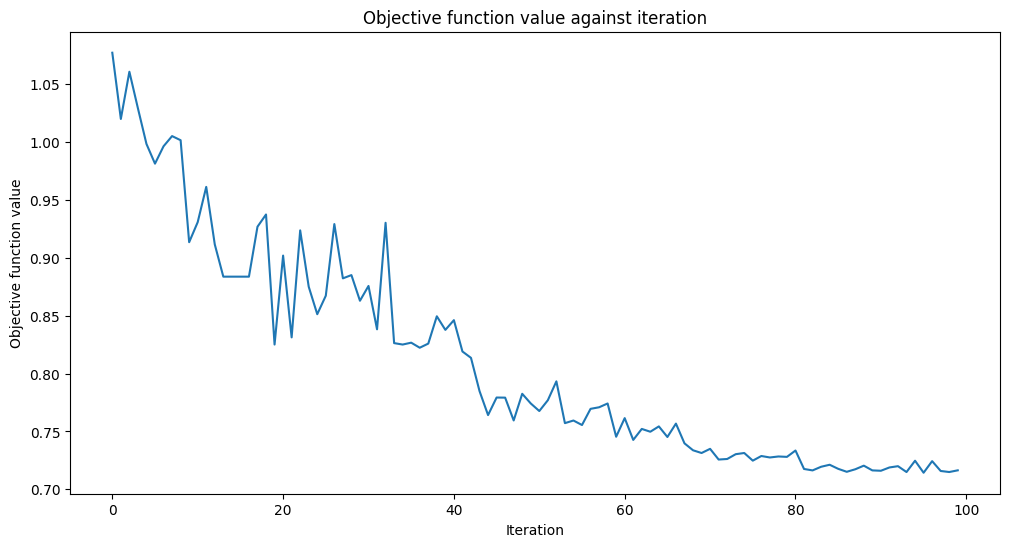

Training time: 80 seconds


In [63]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(X_train, Y_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [99]:
train_score_q4 = vqc.score(X_train, Y_train)
test_score_q4 = vqc.score(X_test, Y_test)


print(f"Quantum QNN on the training dataset: {accuracy(X_train, Y_train, theta, 5000):.2f}")
print(f"Quantum QNN on the test dataset:     {accuracy(X_test, Y_test, theta, 5000):.2f}")
print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum QNN on the training dataset: 0.90
Quantum QNN on the test dataset:     0.94
Quantum VQC on the training dataset: 0.87
Quantum VQC on the test dataset:     0.76


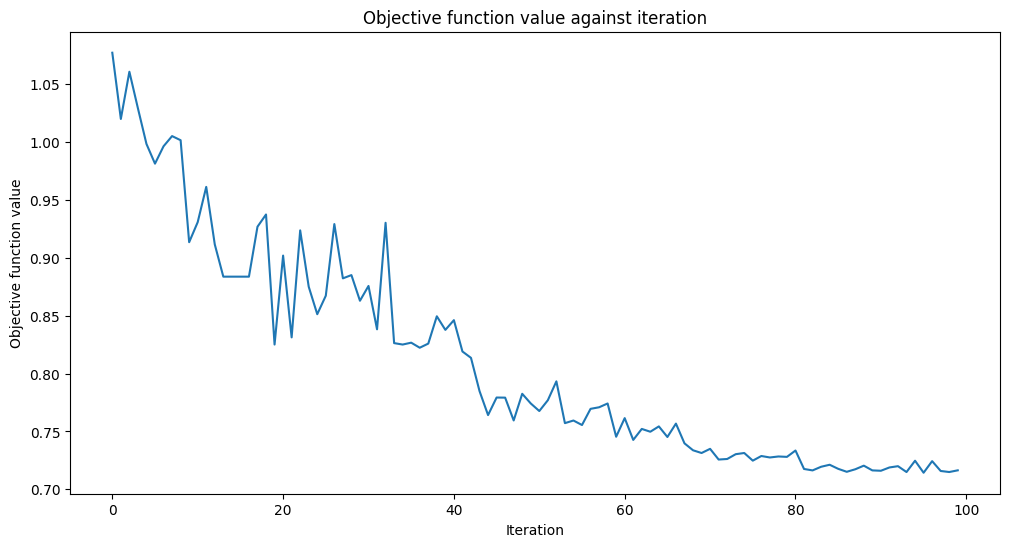

9
Training time: 10097 seconds


In [71]:

train_acc_results_1 = []
test_acc_results_1 = []
train_acc_results_2 = []
test_acc_results_2 = []

start = time.time()

for _ in range(10):
  print(_)
  X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.33, random_state=42)
  theta, loss_list, acc_list, weights_list = model_5(X_train, Y_train, X_test, Y_test, 0.01, 100, [1, 1, 1, 1], 5000, 0.01)
  train_acc_results_1.append(accuracy(X_train, Y_train, theta, 5000))
  test_acc_results_1.append(accuracy(X_test, Y_test, theta, 5000))
  objective_func_vals = []
  vqc.fit(X_train, Y_train)
  train_acc_results_2.append(vqc.score(X_train, Y_train))
  test_acc_results_2.append(vqc.score(X_test, Y_test))
  print(_)

elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [83]:
from numpy.lib.function_base import average

average(train_acc_results_1), average(test_acc_results_1), average(train_acc_results_2), average(test_acc_results_2)

(0.8492537313432835,
 0.8606060606060606,
 0.8656716417910447,
 0.7575757575757576)